In [29]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [31]:
PATH = "/home/ubuntu/data/dogbreeds/"
sz=224
arch=resnext101_64
bs=58
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [32]:
label_csv_filename = f'{PATH}labels.csv'
label_df = pd.read_csv(label_csv_filename)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [33]:
# how many of each class? 
label_df['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
australian_terrier                102
blenheim_spaniel                  102
miniature_pinscher                102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
siberian_husky                     95
norwegian_elkhound                 95
whippet                            95
pug         

In [34]:

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv_filename, test_name='test', 
                                val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
n_labels = len(list(open(label_csv_filename))) - 1  # number of labeled images
val_idxs = get_cv_idxs(n_labels)  # define validation indices  (is random okay if data is ordered?)
print(f'Num labeled images {n_labels}')
print(f'some validation indices: {val_idxs[:10]}')
print(f'Percent of images saved for validation: {100*len(val_idxs)/n_labels}')
# 20% validation is usually fine unless your dataset is small or you need very high accuracy
print(f'Size of training dataset: {len(data.trn_ds)}')
print(f'Size of test dataset: {len(data.test_ds)}')
print(f'Number of classes: {len(data.classes)}')
print(f'First few classes: {data.classes[:5]}')

Num labeled images 10222
some validation indices: [2882 4514 7717   33 4924  532 8028 5860 6054 1543]
Percent of images saved for validation: 19.996086871453727
Size of training dataset: 8178
Size of test dataset: 10357
Number of classes: 120
First few classes: ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier']


A Jupyter Widget

file: /home/ubuntu/data/dogbreeds/train/032c14b2df4193004913b01ab48f87c6.jpg
image size: (500, 333)


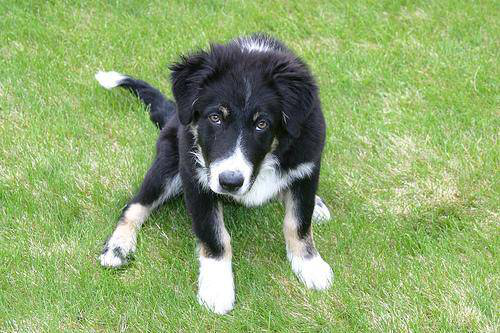

In [35]:
# actually look at images 
# dog is centered and takes of up most of image -- good!
# often medical diagnoses, the tumor/disease will often be a very small part of the image
get_data(sz,bs)
fn = PATH+data.trn_ds.fnames[100]
print(f'file: {fn}')
img = PIL.Image.open(fn)
print(f'image size: {img.size}')
img

(array([ 2870.,  5121.,   128.,    25.,    10.,    15.,     5.,     2.,     0.,     2.]),
 array([  102.,   348.,   594.,   840.,  1086.,  1332.,  1578.,  1824.,  2070.,  2316.,  2562.]),
 <a list of 10 Patch objects>)

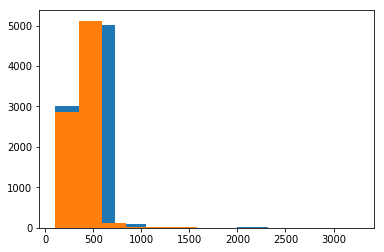

In [36]:
# make sure image sizes are consistent and reasonable 
# most image models are trained in 240x240 or 299x299
size_dist = {kk: PIL.Image.open(PATH+kk).size for kk in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_dist.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz)
plt.hist(col_sz)


(array([  235.,   733.,  2205.,  2979.,  1807.,    98.,    27.,    33.,     7.,    10.]),
 array([ 102.,  190.,  278.,  366.,  454.,  542.,  630.,  718.,  806.,  894.,  982.]),
 <a list of 10 Patch objects>)

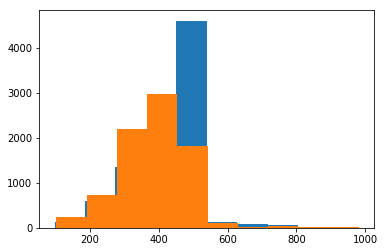

In [37]:
plt.hist(row_sz[row_sz<1000])
plt.hist(col_sz[col_sz<1000])

In [38]:
# part 3. Initial model 

def get_data(sz, bs):
    """
    Return data with changing sz and bs
    It can be faster (and help avoid overfitting) to train on smaller images then work up 
    to bigger images
    
    """
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv_filename, test_name='test', 
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(350, 'tmp')


In [39]:
# 3.1 precompute
sz=224  # often helps to make this small when setting up code initially (fail faster)
arch=resnext101_64
bs=58
n_labels = len(list(open(label_csv_filename))) - 1  # number of labeled images
val_idxs = get_cv_idxs(n_labels)  # define validation indices  (is random okay if data is ordered?)

data = get_data(sz,bs)

A Jupyter Widget

In [40]:
# may need to download weights: http://files.fast.ai/models/weights.tgz
learn = ConvLearner.pretrained(arch, data, precompute=True)  # takes bit to calculate activations

A Jupyter Widget

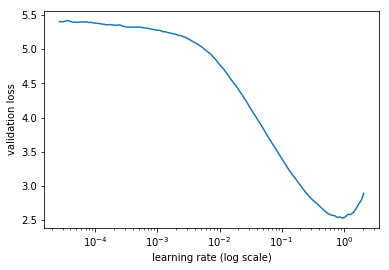

In [41]:
lrf = learn.lr_find() 
learn.sched.plot()

In [42]:
learn.fit(1e-2, 5)
# keep i nmind that accuracy here is predicting the exact right class out of 120 classes (much harder than with only 2 classes)
# so 90% is a very good start (precomupted activations)
# we also exptect training and validation loss to be about equal
# validation loss > training loss => overfitting 
# training loss > validation loss => underfitting (popping out of min, so icnrease cycle_len/mult)

A Jupyter Widget

  5%|▍         | 7/141 [00:00<00:07, 18.83it/s, loss=5.21]

Exception in thread Thread-21:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      0.950208   0.403355   0.904599  
    1      0.43315    0.304254   0.919765                    
    2      0.30077    0.272419   0.921233                    
    3      0.234249   0.262822   0.923679                    
    4      0.189398   0.251187   0.922701                    



[array([ 0.25119]), 0.92270059128330173]

In [43]:
# 3.2 Augment data 

# now use transformations
learn.precompute = False 
learn.fit(1e-2, 5, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.260125   0.244802   0.931507  
    1      0.235519   0.24294    0.925636                    
    2      0.223746   0.2485     0.926614                    
    3      0.199172   0.241951   0.930039                    
    4      0.206591   0.237307   0.928082                    



[array([ 0.23731]), 0.92808219632990441]

In [44]:
# 3.3 try increasing image size 
# super easy way to avoid overfitting
learn.save('224_pre')
learn.load('224_pre')
learn.set_data(get_data(299,bs))
learn.freeze()  # freeze everything but the last layer


A Jupyter Widget

In [45]:
learn.fit(1e-2, 3, cycle_len=1)


A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.204302   0.229157   0.928082  
    1      0.198505   0.223565   0.929061                    
    2      0.170773   0.229372   0.926125                    



[array([ 0.22937]), 0.92612524811768948]

In [46]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.174991   0.225612   0.928571  
    1      0.177535   0.223791   0.927104                    
    2      0.157171   0.222598   0.925636                    
    3      0.156619   0.228406   0.92955                     
    4      0.142441   0.22935    0.926614                    
    5      0.13065    0.228011   0.928571                    
    6      0.115138   0.228397   0.928082                    



[array([ 0.2284]), 0.92808219294725336]

In [73]:
# now try test time augmentation 
# print("HERE")
# log_preds,y = learn.TTA()
# print('here')
# print(log_preds)
# print('Here')
probs = np.exp(log_preds)
# print(probs)
print(y.shape)
print(probs.shape)
print(log_preds.shape)
print(log_preds[0])
print(metrics.log_loss(y, probs[0]))
print(accuracy_np(log_preds[0], y))
#accuracy(log_preds,y), metrics.log_loss(y, probs)

(2044,)
(5, 2044, 120)
(5, 2044, 120)
[[-12.54012 -13.6153  -13.73453 ..., -13.64168 -13.11916 -12.1217 ]
 [-13.51631 -11.18165 -10.83164 ...,  -9.1906  -11.2215  -11.83686]
 [-14.09938 -14.67292 -13.40267 ..., -12.20408 -13.3222  -13.4582 ]
 ..., 
 [-14.6471  -13.63752 -14.72345 ..., -14.06769 -11.07793 -15.14059]
 [-20.2364  -21.5382  -20.29942 ..., -21.24653 -11.90347 -18.81277]
 [-19.47158 -21.11076 -19.18196 ..., -14.81796 -20.08049 -21.23478]]
0.228397457445
0.928082191781


In [75]:
learn.save('299_pre')
learn.load('299_pre')
learn.fit(1e-2, 1, cycle_len=2)
learn.save('299_pre')


A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.125434   0.230454   0.923679  
    1      0.119461   0.230952   0.922701                    



In [76]:
log_preds,y=learn.TTA()
probs = np.exp(log_preds)
accuracy_np(log_preds,y), metrics.log_loss(y,probs)

AttributeError: 'bool' object has no attribute 'mean'